# ResNet 101

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertModel, BertTokenizer
from PIL import Image
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
torch.cuda.is_available()

True

In [3]:
# This is the path for testing on my local machine
base_path = '../../../../dat/EXIST_2025_Videos_Dataset/training/'

# This is the path for running on the PACE Cluster
#base_path = '/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST 2025 Memes Dataset/training/'

file_name = 'EXIST2025_training.json'

#print("path:", train_path)
video_path_col = 'path_video'
target_col = 'labels_task3_1'

In [4]:
class VideoDataset(Dataset):
    def __init__(self, df, transform, max_frames=16):
        #self.video_paths = video_paths
        #self.labels = labels
        self.df = df
        self.transform = transform
        self.max_frames = max_frames
        print(len(self.df))

    def __len__(self):
        return len(self.df)

    def _load_video_frames(self, video_path):
        import cv2
        cap = cv2.VideoCapture(video_path)
        frames = []
        success, frame = cap.read()
        while success and len(frames) < self.max_frames:
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frames.append(self.transform(img))
            success, frame = cap.read()
        cap.release()

        # Pad with zeros if too short
        while len(frames) < self.max_frames:
            frames.append(torch.zeros_like(frames[0]))

        return torch.stack(frames)  # Shape: (T, C, H, W)

    def __getitem__(self, idx):
        video_tensor = self._load_video_frames(base_path + self.df.loc[idx, video_path_col])  # (T, C, H, W)
        label = torch.tensor(self.df.loc[idx, target_col], dtype=torch.long)
        return video_tensor, label

In [5]:
def convert_and_aggregate(label_list):
    binary = [1 if label == "YES" else 0 for label in label_list]
    return Counter(binary).most_common(1)[0][0]

In [6]:


data_df = pd.read_json(base_path+file_name).T[[video_path_col, target_col]]
X = data_df.drop(target_col, axis=1)
y = data_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train_df = pd.concat([X_train, y_train], axis=1)
#test_df = pd.concat([X_test, y_test], axis=1)
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
train_df[target_col] = train_df[target_col].apply(convert_and_aggregate)
test_df[target_col] = test_df[target_col].apply(convert_and_aggregate)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VideoDataset(train_df, transform)
test_dataset = VideoDataset(test_df, transform)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

2019
505


In [7]:
data_df = pd.read_json(base_path+file_name).T
data_df.describe()

,id_Tiktok,id_EXIST,lang,text,video,path_video,url,annotators,number_annotators,gender_annotators,labels_task3_1,labels_task3_2,labels_task3_3,split
count,2524,2524,2524,2524,2524,2524,2524,2524,2524,2524,2524,2524,2524,2524
unique,2524,2524,2,2524,2524,2524,2524,8,2,5,16,32,292,2
top,7218429008445312261,121524,es,palabras que duelen broken_heart femach 8766...,7218429008445312261.mp4,videos/7218429008445312261.mp4,https://www.tiktok.com/@el_temach_3766/video/7...,"[Annotator_4, Annotator_8]",2,"[F, M]","[NO, NO]","[-, -]","[[-], [-]]",TRAIN-VIDEO_ES
freq,1,1,1524,1,1,1,1,572,1780,1438,1069,1069,1069,1524


In [8]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, bottleneck_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(bottleneck_channels, bottleneck_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(bottleneck_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, bottleneck_channels, blocks, stride=1):
        downsample = None
        out_channels = bottleneck_channels * block.expansion

        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [block(self.in_channels, bottleneck_channels, stride, downsample)]
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, bottleneck_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [10]:
class ResNetFeatureExtractor(ResNet):
    def __init__(self, block, layers):
        super().__init__(block, layers)
        self.fc = nn.Identity()  # Remove classification layer

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x  # Features instead of logits

In [11]:

def resnet101_features():
    return ResNetFeatureExtractor(Bottleneck, [3, 4, 23, 3])

In [12]:
class VideoClassificationModel(nn.Module):
    def __init__(self, feature_dim=2048, hidden_dim=512, num_layers=1, num_classes=2):
        super().__init__()
        self.cnn = resnet101_features()
        self.lstm = nn.LSTM(input_size=feature_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, video_frames):
        # video_frames: (batch_size, seq_len, C, H, W)
        batch_size, seq_len, C, H, W = video_frames.shape
        features = []

        for t in range(seq_len):
            frame = video_frames[:, t, :, :, :]  # (B, C, H, W)
            feature = self.cnn(frame)            # (B, 2048)
            features.append(feature)

        features = torch.stack(features, dim=1)  # (B, T, 2048)
        lstm_out, _ = self.lstm(features)        # (B, T, hidden_dim)
        last_hidden = lstm_out[:, -1, :]         # (B, hidden_dim)
        logits = self.classifier(last_hidden)    # (B, num_classes)
        return logits

In [13]:
model = VideoClassificationModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
epochs = 3
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for videos, labels in loop:
        videos, labels = videos.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1:  58%|██████████████████████████████████████████▋                              | 148/253 [02:52<02:02,  1.17s/it, loss=0.723][NULL @ 0x55bec0cfb3c0] Invalid NAL unit size (16738 > 4736).
[NULL @ 0x55bec0cfb3c0] missing picture in access unit with size 4740
[h264 @ 0x55bec1858800] Invalid NAL unit size (16738 > 4736).
[h264 @ 0x55bec1858800] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55beceb26800] stream 1, offset 0x4bf75: partial file
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [04:55<00:00,  1.17s/it, loss=0.611]


Epoch 1 - Loss: 0.6984, Accuracy: 0.5240


Epoch 2:  66%|████████████████████████████████████████████████▍                        | 168/253 [03:16<01:40,  1.18s/it, loss=0.694][NULL @ 0x55bec17ba100] Invalid NAL unit size (16738 > 4736).
[NULL @ 0x55bec17ba100] missing picture in access unit with size 4740
[h264 @ 0x55bec190d0c0] Invalid NAL unit size (16738 > 4736).
[h264 @ 0x55bec190d0c0] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55becebbfe00] stream 1, offset 0x4bf75: partial file
Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [04:55<00:00,  1.17s/it, loss=0.722]


Epoch 2 - Loss: 0.6983, Accuracy: 0.5176


Epoch 3:  40%|█████████████████████████████▏                                           | 101/253 [01:59<03:00,  1.19s/it, loss=0.695][NULL @ 0x55bed08b9c00] Invalid NAL unit size (16738 > 4736).
[NULL @ 0x55bed08b9c00] missing picture in access unit with size 4740
[h264 @ 0x55bec0de1d40] Invalid NAL unit size (16738 > 4736).
[h264 @ 0x55bec0de1d40] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55bed0952700] stream 1, offset 0x4bf75: partial file
Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 253/253 [04:56<00:00,  1.17s/it, loss=0.602]

Epoch 3 - Loss: 0.6939, Accuracy: 0.5443


In [14]:
model.eval()
test_preds, test_probs, test_targets = [], [], []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Evaluating"):
        videos = videos.to(device)
        outputs = model(videos)
        
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())
        test_targets.extend(labels.numpy())

acc = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {acc:.4f}")


probs_df = pd.DataFrame(test_probs, columns=["prob_class_0", "prob_class_1"])
probs_df["predicted_label"] = test_preds
probs_df["true_label"] = test_targets
probs_df.to_csv("resnet.csv", index=False)


Evaluating:  78%|█████████████████████████████████████████████████████████████████▋                  | 50/64 [00:39<00:10,  1.28it/s][NULL @ 0x55becfad52c0] Invalid NAL unit size (34976 > 22622).
[NULL @ 0x55becfad52c0] missing picture in access unit with size 22626
[h264 @ 0x55becfe03a40] Invalid NAL unit size (34976 > 22622).
[h264 @ 0x55becfe03a40] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55becfc6e4c0] stream 1, offset 0x5beee: partial file
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:49<00:00,  1.28it/s]

Test Accuracy: 0.5030


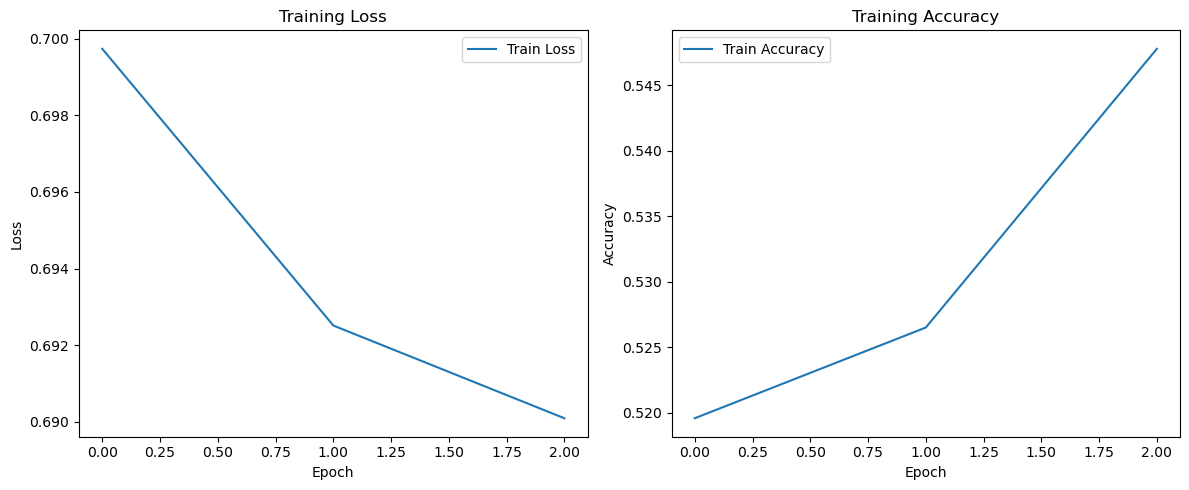

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()